In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import convolve2d

In [2]:
%matplotlib inline

# Negative U-Hubbard Hartree-Fock

## Definitions

### 2D square lattice hopping

In [3]:
def hopping(L=10,t=1):
    bare=np.diag(np.ones(L-1),1)
    bare[-1,0]=t
    h = np.kron(np.eye(L),bare)
    h+= np.kron(bare,np.eye(L))
    h+= h.T
    return h

### Mean field Hamiltonian

In [4]:
def fullHamiltonian(L=10,t=1,mu=[],delta=[]):
   
    if len(delta)==0:
        delta=np.zeros(L*L)
    if len(mu)==0:
        mu=np.zeros(2*L*L)
    
    h_up = hopping(L,t)
    h_up+= np.diag(mu[:L*L])    
    
    h_down = hopping(L,t)
    h_down+= np.diag(mu[L*L:])    
    
    d = -np.diag(delta)
    return np.bmat([[h_up,d],[np.conj(d),-h_down]])

In [5]:
def iteration(maxIter=100,alpha=1,L=10,U=2,m0=0):
    
    delta=    np.ones((L*L,2))
    if isinstance(m0, (list, tuple, np.ndarray)):
        mu = np.ones((2*L*L,2))
        mu[:,0] = m0
    else:
        mu = m0*np.ones((2*L*L,2))
        m0 = m0*np.ones(2*L*L)
        

    ds=np.zeros(maxIter)
    ms=np.zeros((maxIter,2))

    for i in range(maxIter):


        vals,vecs=np.linalg.eigh(fullHamiltonian(L=L,mu=mu[:,0],delta=delta[:,0]))
        gs=np.mat(vecs[:,0:L*L])

        Delta   =  np.diag(np.tensordot(gs.H[:,L*L:],gs[:L*L,:],axes=(0,1)))
        rho_up  =  np.real(np.diag(np.tensordot(gs.H[:,:L*L],gs[:L*L,:],axes=(0,1))))
        rho_down=1-np.real(np.diag(np.tensordot(gs.H[:,L*L:],gs[L*L:,:],axes=(0,1))))

        delta[:,1] = U*Delta
        mu[:L*L,1] = m0[:L*L] + U*rho_up
        mu[L*L:,1] = m0[L*L:] + U*rho_down

        delta[:,0] = alpha*delta[:,1] + (1-alpha)*delta[:,0]
        mu[:,0]    = alpha*mu[:,1] + (1-alpha)*mu[:,0]

        ms[i] = np.array([np.mean(mu[:L*L,0]),np.mean(mu[L*L:,0])])
        ds[i] = np.mean(delta[:,0])

        if i>0:
            if np.mean(abs(np.mean([ms[i]-ms[i-1],ds[i]-ds[i-1]]))) < 1e-5:
                ms=np.resize(ms,(i,2))
                ds=np.resize(ds,i)
                break
    result={}
    result['parameters']={}
    result['parameters']['L']=L
    result['parameters']['m0']=m0
    result['parameters']['U']=U
    result['parameters']['alpha']=alpha
    result['results']={}
    result['results']['deltas']=delta[:,0]
    result['results']['mus']=mu[:,0]
    result['results']['mean_delta']=np.mean(delta[:,0])
    result['results']['mean_mu']=np.mean(mu[:,0])
    result['results']['mean_rho_up']=np.mean(rho_up)
    result['results']['mean_rho_down']=np.mean(rho_down)
    result['results']['rho_up']=rho_up
    result['results']['rho_down']=rho_down
    result['traces']={}
    result['traces']['mean_mus']=ms
    result['traces']['mean_deltas']=ds
    result['results']['spectrum']=vals
    
    return result

## Ramping U

In [6]:
resultsU=[]
for U in np.linspace(0,5,20):
    resultsU.append(iteration(L=20,m0=2,U=U))

In [67]:
d=[]
u=[]
rho=[]
for r in resultsU:
    d.append(r['results']['mean_delta'])
    rho.append(r['results']['mean_rho_up'])
    u.append(r['parameters']['U'])

In [68]:
def gap(x,*params):
    a,b=params
    return a*np.exp(-1/(x*b))

In [69]:
p0=(1,1)
popt,pcov=curve_fit(gap,u[1:],d[1:],p0=p0)

In [70]:
print(popt[0],popt[1])

7.604627893344587 0.10919164412837731


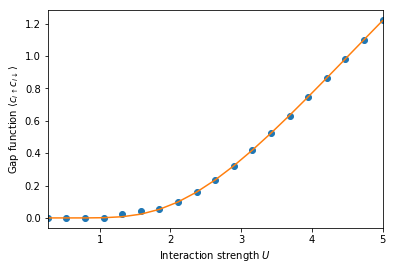

In [71]:
plt.plot(u[1:],d[1:],'o')
plt.plot(u[1:],gap(np.array(u[1:]),*popt))
plt.xlim(u[1],u[-1])
plt.xlabel("Interaction strength $U$")
plt.ylabel("Gap function $\\langle c_{i\\uparrow}c_{i\\downarrow}\\rangle $");

## Ramping m0

In [158]:
resultsMu=[]
for m0 in np.linspace(-7,4,20):
    resultsMu.append(iteration(L=20,m0=m0,U=3))

In [159]:
d=[]
rho=[]
for r in resultsMu:
    d.append(r['results']['mean_delta'])
    rho.append(r['results']['mean_rho_up']+r['results']['mean_rho_down'])

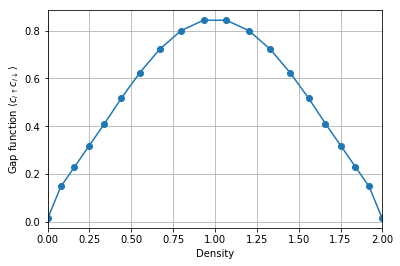

In [160]:
plt.plot(np.array(rho[:]),d[:],'o-')
plt.grid()
plt.xlim(0,2)
plt.xlabel("Density")
plt.ylabel("Gap function $\\langle c_{i\\uparrow}c_{i\\downarrow}\\rangle $");

## Disorder average

In [7]:
L=20
disorder=0.5
mu=0

fltr=np.ones((5,5))/25
bare=np.random.rand(L*L).reshape(L,L)
bare=convolve2d(bare,fltr,mode='same',boundary='wrap').reshape(L*L)
dis=np.array(bare.tolist()*2)

Rslt=iteration(L=L,m0=mu+disorder*dis,U=3)

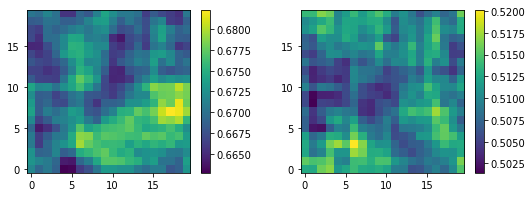

In [203]:
f=plt.figure(figsize=(9,3))
plt.subplot(121)
plt.imshow(Rslt['results']['deltas'].reshape(L,L),origin='lower')
plt.colorbar()
ax = plt.gca()
ax.set_yticks([0,5,10,15])
plt.subplot(122)
plt.imshow(Rslt['results']['rho_up'][:L*L].reshape(L,L)+oneResult['results']['rho_down'][:L*L].reshape(L,L),origin='lower')
ax = plt.gca()
ax.set_yticks([0,5,10,15])
plt.colorbar()